In [34]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from ta.trend import ADXIndicator


#### Load data

In [35]:
df = pd.read_csv("data/btc_1m.csv", parse_dates=['timestamp'])
df.set_index("timestamp", inplace=True)

In [36]:
def preprocess_data(df, price_col="close"):
    # price change between now and 5 minutes later
    df['target_5m'] = df[price_col].shift(-5) - df[price_col]
    df['target_30m'] = df[price_col].shift(-30) - df[price_col]

    # a few technical indicators using ta

    df['sma_10_diff'] = df[price_col].rolling(window=10).mean() - df[price_col]
    df['sma_30_diff'] = df[price_col].rolling(window=30).mean() - df[price_col]

    if 'high' in df.columns and 'low' in df.columns:
        df['adx'] = ADXIndicator(high=df['high'], low=df['low'], close=df[price_col], window=14).adx()
    df['rsi'] = (df[price_col].diff(1).gt(0).rolling(window=14).sum() / 14) * 100
    df['macd'] = df[price_col].ewm(span=12, adjust=False).mean() - df[price_col].ewm(span=26, adjust=False).mean()
    df['bollinger_high_diff'] = df[price_col].rolling(window=20).mean() + (df[price_col].rolling(window=20).std() * 2) - df[price_col]
    df['bollinger_low_diff'] = df[price_col].rolling(window=20).mean() - (df[price_col].rolling(window=20).std() * 2) - df[price_col]

    df['bb_width'] = (df['bollinger_high_diff'] - df['bollinger_low_diff']) / df[price_col].rolling(window=20).mean()

    df['atr'] = df[price_col].rolling(window=14).apply(lambda x: np.max(x) - np.min(x), raw=True)
    df['roc_5'] = (df[price_col] - df[price_col].shift(5)) / df[price_col].shift(5) * 100

    df['high_14'] = df[price_col].rolling(window=14).max()
    df['low_14'] = df[price_col].rolling(window=14).min()
    df['stoch_k'] = 100 * (df[price_col] - df['low_14']) / (df['high_14'] - df['low_14'])
    df['stoch_d'] = df['stoch_k'].rolling(window=3).mean()  # 3-period SMA of %K
    df = df.drop(['high_14', 'low_14'], axis=1)  # Clean up temporary columns

    df['returns'] = df[price_col].pct_change()
    df['hist_vol_14'] = df['returns'].rolling(window=14).std() * np.sqrt(252)  # Annualized
    df = df.drop('returns', axis=1)

    df['hour'] = df.index.hour
    df['minute'] = df.index.minute
    df['is_open'] = (df['hour'] > 9) & (df['hour'] < 15)
    
    return df

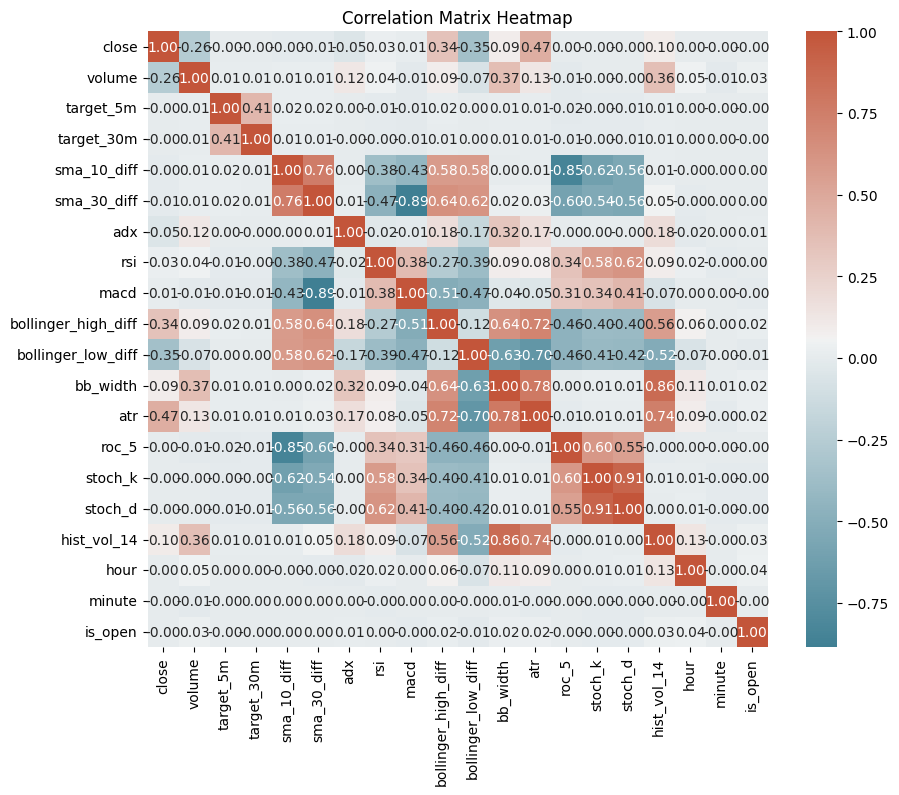

In [37]:
data = preprocess_data(df)
data = data.dropna()

data = data.drop(columns=['open','high','low',])


import seaborn as sns
corr = data.corr()  # Correlation matrix
plt.figure(figsize=(10, 8))
#gtreen to purple color map
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(corr, cmap=cmap, annot=True, fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()

# Scale price values
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

In [38]:

# Parameters
lookback = 30  # lookback minutes of past data
pred10 = 5    # predict 10 minutes ahead
pred30 = 30    # predict 30 minutes ahead

data_scaled_df = pd.DataFrame(data_scaled, columns=data.columns)

# Convert scaled data to NumPy array for faster processing
data_scaled_array = data_scaled_df.values  # shape: (n_samples, n_features)
feature_cols = [col for col in data_scaled_df.columns if col not in ['target_5m', 'target_30m']]
feature_indices = [data_scaled_df.columns.get_loc(c) for c in feature_cols]

# Compute number of samples
n_samples = len(data_scaled_df) - lookback - pred30 + 1

# Use stride_tricks for efficient sliding window
from numpy.lib.stride_tricks import sliding_window_view
X = sliding_window_view(data_scaled_array[pred30:, feature_indices], (lookback, len(feature_indices)))[::1, 0, :, :]  # shape: (n_samples, lookback, n_features)

# Allocate y array
y = np.empty((n_samples, 1))

# Extract targets with corrected indexing
# For each sample i, X covers rows [i:i+lookback], and we need targets at i+lookback+pred10-1 and i+lookback+pred30-1
start_idx = lookback  # Start of the first valid target
y[:, 0] = data['target_5m'].values[start_idx + pred10 - 1 : start_idx + pred10 - 1 + n_samples]
# y[:, 1] = data['target_30m'].values[start_idx + pred30 - 1 : start_idx + pred30 - 1 + n_samples]

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (1335232, 30, 18)
y shape: (1335232, 1)


In [39]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

len(X_train), len(X_test), len(y_train), len(y_test)

(1068185, 267047, 1068185, 267047)

In [40]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [41]:
# LSTM model
model = Sequential([
    LSTM(64, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)  # 2 outputs: 10m and 30m future prices
])

model.compile(
    loss='mean_squared_error',
    optimizer='adam',
    metrics=['mae']
)

# Early stopping (optional but useful)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=8,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

c:\Users\chris\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/8
13353/13353 ━━━━━━━━━━━━━━━━━━━━ 134s 10ms/step - loss: 2167.4832 - mae: 24.7768 - val_loss: 1878.1377 - val_mae: 26.6908
Epoch 2/8
13353/13353 ━━━━━━━━━━━━━━━━━━━━ 165s 12ms/step - loss: 608.7015 - mae: 14.3773 - val_loss: 916.7165 - val_mae: 18.0396
Epoch 3/8
13353/13353 ━━━━━━━━━━━━━━━━━━━━ 244s 18ms/step - loss: 281.5809 - mae: 9.9894 - val_loss: 425.5462 - val_mae: 10.5012
Epoch 4/8
13353/13353 ━━━━━━━━━━━━━━━━━━━━ 234s 18ms/step - loss: 142.7885 - mae: 7.1440 - val_loss: 234.5936 - val_mae: 6.5917
Epoch 5/8
13353/13353 ━━━━━━━━━━━━━━━━━━━━ 267s 20ms/step - loss: 112.8518 - mae: 6.2983 - val_loss: 208.4934 - val_mae: 5.9906
Epoch 6/8
13353/13353 ━━━━━━━━━━━━━━━━━━━━ 237s 18ms/step - loss: 91.8682 - mae: 5.6663 - val_loss: 536.2443 - val_mae: 18.6293
Epoch 7/8
13353/13353 ━━━━━━━━━━━━━━━━━━━━ 219s 16ms/step - loss: 80.0465 - mae: 5.1706 - val_loss: 185.3858 - val_mae: 6.7159
Epoch 8/8
13353/13353 ━━━━━━━━━━━━━━━━━━━━ 175s 13ms/step - loss: 63.9447 - mae: 4.7893 - val_loss

In [42]:
# Evaluate on test set
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test MAE: {test_mae:.6f}")

# Predict
y_pred = model.predict(X_test)

# Inverse scale to get real prices
# y_test_rescaled = scaler.inverse_transform(np.concatenate([y_test, y_test[:, :1]], axis=1))[:, :2]
# y_pred_rescaled = scaler.inverse_transform(np.concatenate([y_pred, y_pred[:, :1]], axis=1))[:, :2]
# 4ms/step - loss: 664.3267 - mae: 14.4296

8346/8346 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step - loss: 321.7066 - mae: 8.1657
Test MAE: 7.453061
8346/8346 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step


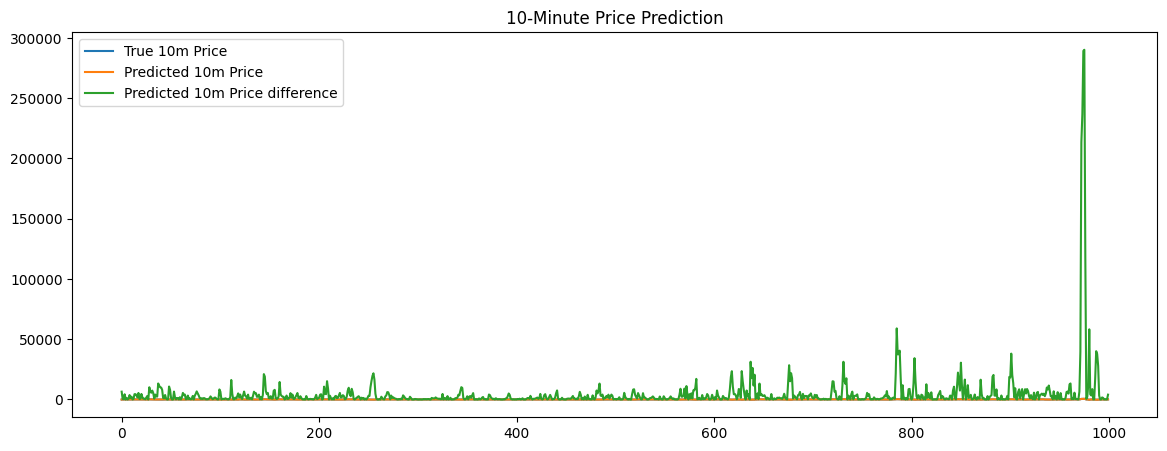

In [47]:
display_count = 1000

plt.figure(figsize=(14, 5))
plt.plot(y_test[:display_count, 0], label='True 10m Price')
plt.plot(y_pred[:display_count, 0], label='Predicted 10m Price')
plt.plot(y_pred[:display_count, 0] * y_test[:display_count, 0], label='Predicted 10m Price difference')

plt.title("10-Minute Price Prediction")
plt.legend()
plt.show()

# plt.figure(figsize=(14, 5))
# plt.plot(y_test[:display_count, 1], label='True 30m Price')
# plt.plot(y_pred[:display_count, 1] * 100, label='Predicted 30m Price')
# # plt.plot(y_pred[:display_count, 1] * 5 - y_test[:display_count, 1], label='Predicted 30m Price')
# plt.title("30-Minute Price Prediction")
# plt.legend()
# plt.show()


In [80]:
def mock_trade(X_test, y_pred_scaled, data, price_col='close', trade_count=1000, threshold=50, close_after=5, trading_fee=0.00042, initial_bankroll=1.0,):
    bankroll = initial_bankroll
    trades = []
    position_size = 1  # Fixed position size (1 unit of asset)
    
    # Get the index of the price column in the original data for rescaling
    price_col_idx = data.columns.get_loc(price_col)
    target_5m_idx = data.columns.get_loc('target_5m')
    
    test_length = trade_count

    # Predict on test set
    
    final_trades = []

    trade_list = []

    for i in range(len(X_test[:test_length])):
        # Get the current price
        current_price = data.iloc[len(X_train) + 1 + i][0]


        # # Get the predicted target price
        predicted_target_price = y_pred_scaled[i, 0]

        if abs(predicted_target_price) > threshold and len(trade_list) == 0:
                
            # Simulate the trade
            trade = {
                'enter_at': i,
                'entry_price': current_price,
                'predicted_target_price': predicted_target_price,
                'direction': 'buy' if predicted_target_price > 0 else 'sell',
                'position_size': position_size,
                'trading_fee': trading_fee
            }

            trade_list.append(trade)

        removed_trades = []

        before = bankroll

        # Check if the trade hits stop-loss or take-profit
        for trade in trade_list:
            if i - trade['enter_at'] >= close_after:
                if trade['direction'] == 'buy':
                    bankroll *= current_price / trade['entry_price'] * (1 - trade['trading_fee'])
                    trade['exit_as'] = 'profit' if current_price / trade['entry_price'] > 1 else 'loss'

                else:
                    bankroll *= trade['entry_price'] / current_price * (1 - trade['trading_fee'])
                    trade['exit_as'] = 'profit' if current_price / trade['entry_price'] < 1 else 'loss'
                    
                trade['exit_at'] = i
                trade['exit_price'] = current_price
                removed_trades.append(trade)

        after = bankroll

        # if before != after:
        #     print(f"Trade executed at index {i}: Bankroll changed from {before:.8f} to {after:.8f}, {after/before:.8f} times initial bankroll")
               

        # Remove trades that were executed
        for trade in removed_trades:
            trade_list.remove(trade)
            final_trades.append(trade)

    return bankroll, pd.DataFrame(final_trades)

                
   



In [81]:
test_length = len(X_test)
y_pred_scaled = model.predict(X_test[:test_length])  # Shape: (n_test_samples, 1)

8346/8346 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step


In [83]:
# Run mock trading
final_bankroll, trades_df = mock_trade(
    X_test, y_pred_scaled, data, 
    trade_count = test_length,
    threshold=100, trading_fee=0.00042,
)

C:\Users\chris\AppData\Local\Temp\ipykernel_22844\1978233226.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  current_price = data.iloc[len(X_train) + 1 + i][0]


Final Bankroll: 5.3224690298259984e-05
Average Trade Duration: 5.0 steps

Trade Summary:
exit_as
profit    12308
loss      12073
Name: count, dtype: int64
exit_as
profit    50.481933
loss      49.518067
Name: proportion, dtype: float64


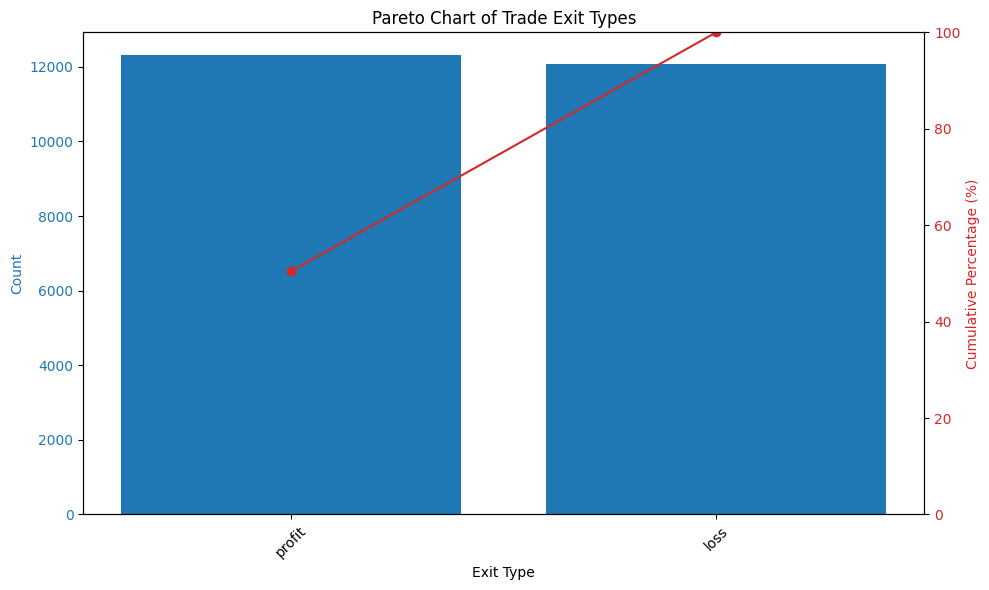

In [84]:

print(f"Final Bankroll: {final_bankroll}")
#print average duration of trades
average_duration = trades_df['exit_at'] - trades_df['enter_at']
print(f"Average Trade Duration: {average_duration.mean()} steps")
print("\nTrade Summary:")
# print(trades_df)

# print distribution of trades exiting at stop-loss or take-profit
print(trades_df['exit_as'].value_counts())
#print as percentages
print(trades_df['exit_as'].value_counts(normalize=True) * 100)
# Get value counts and sort in descending order
exit_counts = trades_df['exit_as'].value_counts().sort_values(ascending=False)


# Calculate cumulative percentage
cumulative_percentage = exit_counts.cumsum() / exit_counts.sum() * 100

# Create Pareto chart
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for counts
ax1.bar(exit_counts.index, exit_counts.values, color='tab:blue')
ax1.set_xlabel('Exit Type')
ax1.set_ylabel('Count', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
plt.xticks(rotation=45)

# Create second y-axis for cumulative percentage
ax2 = ax1.twinx()
ax2.plot(exit_counts.index, cumulative_percentage, color='tab:red', marker='o')
ax2.set_ylabel('Cumulative Percentage (%)', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.set_ylim(0, 100)

# Title and layout
plt.title('Pareto Chart of Trade Exit Types')
fig.tight_layout()

plt.show()